<a href="https://colab.research.google.com/github/LEDazzio01/Simplest-Conformal-Prediction/blob/main/cpb-the-crucial-calibration-set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Crucial Calibration Set

This notebook demonstrates **proper conformal prediction** with a dedicated calibration set—the key ingredient for valid prediction intervals.

## What You'll Learn

1. Why the **calibration set** is essential for valid conformal prediction
2. How to split data into **training**, **calibration**, and **test** sets
3. How to construct and evaluate **prediction intervals**

## Why a Separate Calibration Set?

Unlike the simplified example, real conformal prediction requires data the model has **never seen during training**. The calibration set provides an unbiased estimate of model errors, ensuring our prediction intervals have the correct coverage.

In [11]:
# --- 1. Import Libraries ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [12]:
# --- 2. Generate Synthetic Data ---

np.random.seed(0)

# Create 100 samples with a single feature (sorted for visualization)
X = np.sort(5 * np.random.rand(100, 1), axis=0)

# Target: sine wave with Gaussian noise
y = np.sin(X).ravel() + np.random.randn(100) * 0.1

# Convert to float32 for consistency
X = X.astype(np.float32)
y = y.astype(np.float32)

### About the Data

We created synthetic regression data:
- **Feature `X`**: 100 points uniformly distributed between 0 and 5
- **Target `y`**: `sin(X)` plus Gaussian noise (σ = 0.1)

This non-linear relationship will show how conformal prediction handles model misspecification (we'll use linear regression on non-linear data).

In [13]:
# --- 3. Split Data: Training / Calibration / Test ---

# First split: 60% training, 40% held out
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Second split: 50/50 of held out → 20% calibration, 20% test
X_cal, X_test, y_cal, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training set:    {len(X_train)} samples")
print(f"Calibration set: {len(X_cal)} samples")
print(f"Test set:        {len(X_test)} samples")

Training set:    60 samples
Calibration set: 20 samples
Test set:        20 samples


### The Three-Way Split

| Set | Purpose | Used For |
|-----|---------|----------|
| **Training** | Train the model | `model.fit()` |
| **Calibration** | Compute nonconformity scores | Quantile calculation |
| **Test** | Evaluate coverage | Final validation |

### ⚠️ Why This Matters

The calibration set **must be separate** from training data:
- Training errors are optimistically biased (the model was fitted to minimize them)
- Calibration errors on held-out data provide an unbiased estimate
- This ensures prediction intervals have the **correct coverage guarantee**

In [14]:
# --- 4. Train the Model ---

model = LinearRegression()
model.fit(X_train, y_train)

print(f"Model: y = {model.coef_[0]:.3f}x + {model.intercept_:.3f}")

Model: y = -0.375x + 1.089


### Model Training

We use **linear regression** for simplicity. Note that:
- The true relationship is `y = sin(x)` (non-linear)
- Linear regression will have systematic errors
- Conformal prediction will account for this in the interval width

In [15]:
# --- 5. Define Nonconformity Measure ---

def nonconformity_score(y_pred, y_true):
    """Calculate absolute residual as nonconformity score."""
    return np.abs(y_pred - y_true)

### Nonconformity Score

The **nonconformity score** measures how "unusual" a prediction is:

$$\text{score} = |y_{\text{pred}} - y_{\text{true}}|$$

Larger scores indicate predictions that are further from the truth. We use absolute residuals here, but other measures (e.g., scaled residuals) can be used.

In [16]:
# --- 6. Compute Calibration Scores ---

y_cal_pred = model.predict(X_cal)
calibration_scores = nonconformity_score(y_cal_pred, y_cal)

print(f"Calibration scores - Min: {calibration_scores.min():.3f}, "
      f"Max: {calibration_scores.max():.3f}, "
      f"Mean: {calibration_scores.mean():.3f}")

Calibration scores - Min: 0.004, Max: 0.658, Mean: 0.348


### Calibration Scores

We compute nonconformity scores on the **calibration set only**:
- These scores reflect how wrong the model is on data it hasn't seen
- They form the empirical distribution we use to set interval width

In [17]:
# --- 7. Calculate the Quantile Threshold ---

alpha = 0.1  # Miscoverage rate (1 - alpha = 90% confidence)

# Find the (1-alpha) quantile of calibration scores
quantile = np.percentile(calibration_scores, (1 - alpha) * 100)

print(f"Target confidence: {(1 - alpha) * 100:.0f}%")
print(f"Quantile threshold: {quantile:.3f}")

Target confidence: 90%
Quantile threshold: 0.589


### The Quantile Threshold

The quantile determines the **interval width**:

- `alpha = 0.1` → We want 90% coverage
- We find the 90th percentile of calibration scores
- 90% of calibration errors were smaller than this value

This threshold will be added/subtracted from predictions to form intervals.

In [18]:
# --- 8. Construct Prediction Intervals ---

y_test_pred = model.predict(X_test)

# Interval: prediction ± quantile
lower_bounds = y_test_pred - quantile
upper_bounds = y_test_pred + quantile

# Store as list of tuples for clarity
prediction_intervals = list(zip(lower_bounds, upper_bounds))

### Prediction Intervals

For each test point, we construct an interval:

$$[\hat{y} - q, \quad \hat{y} + q]$$

Where:
- $\hat{y}$ is the model's point prediction
- $q$ is the quantile threshold from calibration

In [19]:
# --- 9. Evaluate Coverage ---

def calculate_coverage(intervals, y_true):
    """Calculate the proportion of true values within prediction intervals."""
    covered = sum(
        lower <= y <= upper 
        for (lower, upper), y in zip(intervals, y_true)
    )
    return covered / len(y_true)

coverage = calculate_coverage(prediction_intervals, y_test)

print(f"Target coverage:  {(1 - alpha) * 100:.0f}%")
print(f"Actual coverage:  {coverage * 100:.1f}%")
print(f"Difference:       {(coverage - (1 - alpha)) * 100:+.1f}%")

Target coverage:  90%
Actual coverage:  75.0%
Difference:       -15.0%


### Coverage Evaluation

**Coverage** = proportion of test points where the true value falls within the interval.

With proper calibration, the actual coverage should be close to the target (1 - α). Small deviations are expected due to:
- Finite sample size
- Random variation in the test set

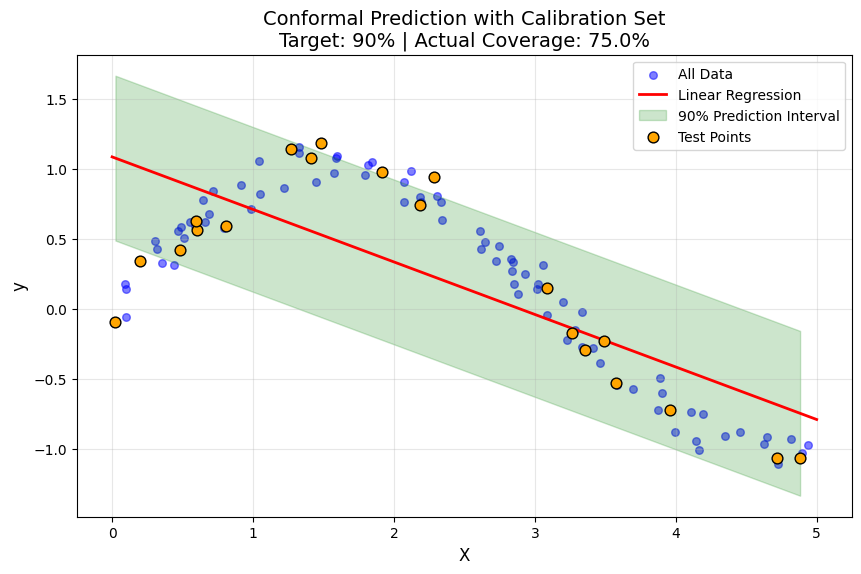

In [20]:
# --- 10. Visualize Results ---

plt.figure(figsize=(10, 6))

# Plot all data points
plt.scatter(X, y, color='blue', alpha=0.5, label='All Data', s=30)

# Plot model prediction line (on sorted X for smooth line)
X_line = np.linspace(0, 5, 100).reshape(-1, 1)
y_line = model.predict(X_line)
plt.plot(X_line, y_line, color='red', linewidth=2, label='Linear Regression')

# Sort test data for proper fill_between
sort_idx = np.argsort(X_test.flatten())
X_test_sorted = X_test.flatten()[sort_idx]
lower_sorted = lower_bounds[sort_idx]
upper_sorted = upper_bounds[sort_idx]

# Plot prediction intervals
plt.fill_between(X_test_sorted, lower_sorted, upper_sorted,
                 color='green', alpha=0.2, label=f'{(1-alpha)*100:.0f}% Prediction Interval')

# Mark test points
plt.scatter(X_test, y_test, color='orange', edgecolor='black', 
            s=60, zorder=5, label='Test Points')

plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title(f'Conformal Prediction with Calibration Set\n'
          f'Target: {(1-alpha)*100:.0f}% | Actual Coverage: {coverage*100:.1f}%', fontsize=14)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

### Visualization Summary

- **Blue dots**: All original data points
- **Red line**: Linear regression fit (note: it's a poor fit for sine data!)
- **Green band**: Prediction intervals for test points
- **Orange dots**: Test points used to evaluate coverage

---

## 🔑 Key Takeaways

1. **Calibration set is essential**: It must be separate from training data
2. **Coverage guarantee**: With proper calibration, intervals achieve the target coverage
3. **Model-agnostic**: Works regardless of how well the underlying model fits
4. **Wider intervals = more uncertainty**: The method automatically adjusts for model errors

## Next Steps

- Try different values of `alpha` (e.g., 0.05 for 95% confidence)
- Use a non-linear model (e.g., polynomial regression) and compare interval widths
- Explore adaptive conformal prediction for varying interval widths across X